In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import os
from IPython.display import display
import time
a = time.time()

Nous étudions dans ce notebook le modèle de **regression logistique**.

# 1. Chargement d'une base Sentiment140 préprocessée 

On travaille tout d'abord avec un pré-processing fixé.

In [2]:
NB_DATA = 200000

In [3]:
STOP_WORDS = False
LEMMATIZATION = False
NEGATION = False
file = "train"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
if NEGATION:
    file += "_neg"
df = pd.read_pickle(os.path.join("data", "sentiment140", file + ".bz2")).sample(NB_DATA, random_state=1234)

In [4]:
df.head(10)

,sentiment,id,date,query_string,user,text
599410,Negative,2220663113,Thu Jun 18 03:39:49 PDT 2009,NO_QUERY,gemgembam,open itunes will not open naooo the silence is...
549856,Negative,2202759103,Tue Jun 16 22:21:43 PDT 2009,NO_QUERY,twistofcolour,the sun is already gone for the day
1363048,Positive,2049441111,Fri Jun 05 16:53:10 PDT 2009,NO_QUERY,Niico1e,hiya this is my st tweet i am so tired though ...
558776,Negative,2204830292,Wed Jun 17 03:14:38 PDT 2009,NO_QUERY,MeriEsteban,i have the bac today at p m i do not know if i...
1582398,Positive,2190306594,Tue Jun 16 02:21:03 PDT 2009,NO_QUERY,MeghanMagnolia,as far as i remember you were not half bad ine...
1353343,Positive,2046706853,Fri Jun 05 12:34:26 PDT 2009,NO_QUERY,WahooPooh,as tempting as that is i am just waiting on my...
586354,Negative,2215937155,Wed Jun 17 18:49:10 PDT 2009,NO_QUERY,amandarie,cool how i have to be stuck at home i want to ...
860355,Positive,1676343245,Fri May 01 21:46:07 PDT 2009,NO_QUERY,MatchesMalone,oh and followfriday my writing partner because...
521668,Negative,2192486836,Tue Jun 16 07:06:35 PDT 2009,NO_QUERY,hockeyfan45214,you would think if i continue to block someone...
243888,Negative,1981647618,Sun May 31 09:35:54 PDT 2009,NO_QUERY,ilovemytroops,nevaeh buchanan missing friends of her mother ...


In [5]:
X = df.text.to_list()
y = df.sentiment.to_list()

# 2. Différentes méthodes de feature extraction
## 2.1. Count Vectorizer
### 2.1.1. Exemple

In [6]:
array = ["Car was cleaned by Jack", 
         "Jack was cleaned by Car", 
         "Hello"]
vectorizer = CountVectorizer()
X_ = vectorizer.fit_transform(array)
vectorizer.get_feature_names()

['by', 'car', 'cleaned', 'hello', 'jack', 'was']

L'encodage de la table `array` par la méthode **Count Vectorizer** est : 

In [7]:
print(X_.toarray())

[[1 1 1 0 1 1]
 [1 1 1 0 1 1]
 [0 0 0 1 0 0]]


### 2.1.2. Application de la regression logistique

In [8]:
def conf_matrix(X, y, vectorizer, model, verbose=True):
    X = vectorizer.fit_transform(X).toarray()
    X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, train_size=0.80, random_state=1234)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
    sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
    sc_f1 = metrics.f1_score(y_pred, y_test, pos_label="Positive")
    sc_recall = metrics.recall_score(y_pred, y_test, pos_label="Positive")
    sc_precision = metrics.precision_score(y_pred, y_test, pos_label="Positive")
    sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    probs = model.predict_proba(X_test)[:, 1]

    if verbose:
        metrics.plot_confusion_matrix(model, X_test, y_test)
        plt.show()

        print(f"Accuracy : {sc_accuracy}")
        print(f"Balanced accuracy : {sc_balanced_accuracy}")
    #     print(f"Recall : {sc_recall}")
    #     print(f"Precision : {sc_precision}")
    #     print(f"F1 : {sc_f1}")
        print(f"ROC AUC : {sc_roc_auc}")

    metrics_score = {'accuracy': sc_accuracy, 'balanced_accuracy': sc_balanced_accuracy, 'roc_auc': sc_roc_auc}

    if not verbose:
        return X_train, X_test, y_train, y_test, probs, metrics_score  

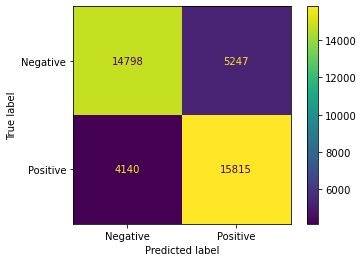

Accuracy : 0.765325
Balanced accuracy : 0.7661351347873979
ROC AUC : 0.8379636471909638


In [9]:
conf_matrix(X, y, CountVectorizer(max_features=1000), LogisticRegression())

## 2.2. TF-IDF
### 2.2.1. Exemple

In [10]:
array = ["Blue car was cleaned by Jack", 
         "Jack was cleaned by red car", 
         "Hello"]
vectorizer = TfidfVectorizer()
X_ = vectorizer.fit_transform(array)
vectorizer.get_feature_names()

['blue', 'by', 'car', 'cleaned', 'hello', 'jack', 'red', 'was']

L'encodage de la table `array` par la méthode **TD-IDF** est : 

In [11]:
print(X_.toarray())

[[0.50689001 0.38550292 0.38550292 0.38550292 0.         0.38550292
  0.         0.38550292]
 [0.         0.38550292 0.38550292 0.38550292 0.         0.38550292
  0.50689001 0.38550292]
 [0.         0.         0.         0.         1.         0.
  0.         0.        ]]


### 2.2.2. Application de la regression logistique

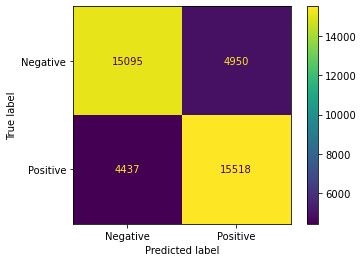

Accuracy : 0.765325
Balanced accuracy : 0.7654967003732565
ROC AUC : 0.8448906785090599


In [12]:
conf_matrix(X, y, TfidfVectorizer(max_features=1000), LogisticRegression())

## 2.3. N-grams

La méthode N-grams peut-être utilisé sur les méthodes **Count Vectorizer** et **TD-IDF**.

### 2.3.1. Exemple

In [13]:
arr = ["Blue car was cleaned by Jack", "Jack was cleaned by red car", "Hello"]
vectorizer = CountVectorizer(ngram_range=(2, 2))
X_ = vectorizer.fit_transform(arr)
vectorizer.get_feature_names()

['blue car',
 'by jack',
 'by red',
 'car was',
 'cleaned by',
 'jack was',
 'red car',
 'was cleaned']

L'encodage de la table `array` par les méthodes **Count Vectorizer et N-grams** est : 

In [14]:
print(X_.toarray())

[[1 1 0 1 1 0 0 1]
 [0 0 1 0 1 1 1 1]
 [0 0 0 0 0 0 0 0]]


### 2.3.2. Application de la regression logistique

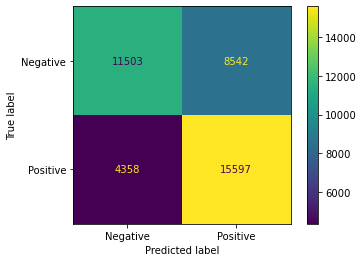

Accuracy : 0.6775
Balanced accuracy : 0.6856854096440728
ROC AUC : 0.7478925199558824


In [15]:
conf_matrix(X, y, CountVectorizer(max_features=1000, ngram_range=(2, 2)), LogisticRegression(max_iter=200))

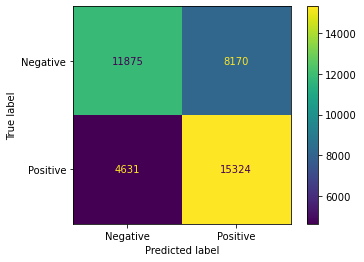

Accuracy : 0.679975
Balanced accuracy : 0.6858434977781025
ROC AUC : 0.7493454173111751


In [16]:
conf_matrix(X, y, TfidfVectorizer(max_features=1000, ngram_range=(2, 2)), LogisticRegression(max_iter=200))

# 3. Comparaisons des méthodes de feature extraction

L'objectif est de comparer les 3 méthodes de feature extraction **Count Vectorizer**, **TD-IDF** et **N-grams**, en faisant ensuite varier la méthode de pré-processing et le nombre de features.
Nous pourrons alors en déduire la combinaison optimale pour la **regression logistique**.

## 3.1. Comparaison des méthodes de feature extraction à pré-processing fixé et avec un nombre de features fixé

On compare les méthodes de feature extraction à pré-processing fixé et avec un nombre de features fixé pour l'instant.

In [17]:
def comparaison(X, y, N, show_graph=True, show_table=True):
    """
    N correspond au nombre de features
    """
    table = []

    _, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N), LogisticRegression(max_iter=200), verbose=False)
    fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
    if show_graph: plt.plot(fpr, tpr, ":", label=f"CountVectorizer {N}")
    table.append(metrics_score)

    _, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N), LogisticRegression(max_iter=200), verbose=False)
    fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
    if show_graph: plt.plot(fpr, tpr, ":", label=f"TfidfVectorizer {N}")
    table.append(metrics_score)

    _, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N, ngram_range=(2,2)), LogisticRegression(max_iter=200), verbose=False)
    fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
    if show_graph: plt.plot(fpr, tpr, ":", label=f"CountVectorizer {N} ngram 2")
    table.append(metrics_score)

    _, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N, ngram_range=(2,2)), LogisticRegression(max_iter=200), verbose=False)
    fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
    if show_graph: plt.plot(fpr, tpr, ":", label=f"TfidfVectorizer {N} ngram 2")
    table.append(metrics_score)
    
    if show_graph:
        plt.plot([0, 1], [0, 1], "r-")
        plt.plot([0, 0, 1], [0, 1, 1], 'b-')
        plt.legend()
        plt.show()

    if show_table:
        display(pd.DataFrame(table, index=[f"CountVectorizer {N}", f"TfidfVectorizer {N}", f"CountVectorizer {N} ngram 2", f"TfidfVectorizer {N} ngram 2"]))

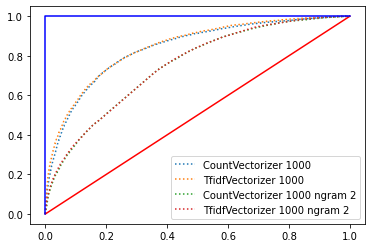

,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.765325,0.766135,0.837964
TfidfVectorizer 1000,0.765325,0.765497,0.844891
CountVectorizer 1000 ngram 2,0.677500,0.685685,0.747893
TfidfVectorizer 1000 ngram 2,0.679975,0.685843,0.749345


Wall time: 1min 14s


In [18]:
%%time
comparaison(X, y, 1000)

**Conclusion :** Le modèle de feature extraction le plus performant (pour la méthode de pré-processing fixée et le nombre de features fixé) est ici le `TfidfVectorizer`. L'ajout de la fonction ngram demande en fait d'augmenter le nombre de features (de $n$ à $n^2$), ce qui demande plus de temps de calcul : 

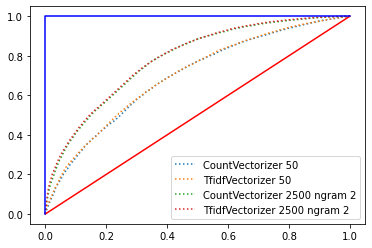

Wall time: 1min 58s


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 50,0.643750,0.645314,0.694919
TfidfVectorizer 50,0.643775,0.644301,0.698558
CountVectorizer 2500 ngram 2,0.710375,0.715866,0.782681
TfidfVectorizer 2500 ngram 2,0.711550,0.715121,0.786758


In [19]:
%%time
table = []

N = 50

_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N), LogisticRegression(max_iter=200), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"CountVectorizer {N}")
table.append(metrics_score)

_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N), LogisticRegression(max_iter=200), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"TfidfVectorizer {N}")
table.append(metrics_score)


_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N**2, ngram_range=(2,2)), LogisticRegression(max_iter=200), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"CountVectorizer {N**2} ngram 2")
table.append(metrics_score)


_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N**2, ngram_range=(2,2)), LogisticRegression(max_iter=200), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"TfidfVectorizer {N**2} ngram 2")
table.append(metrics_score)

plt.plot([0, 1], [0, 1], "r-")
plt.plot([0, 0, 1], [0, 1, 1], 'b-')

plt.legend()
plt.show()

pd.DataFrame(table, index=[f"CountVectorizer {N}", f"TfidfVectorizer {N}", f"CountVectorizer {N**2} ngram 2", f"TfidfVectorizer {N**2} ngram 2"])

On peut voir qu'en prenant $n$ et $n^2$, les courbes se rapprochent un peu, mais il faudrait encore augmenter le nombre de features pour les méthodes ngram pour égaler les méthodes non ngram.

## 3.2. Influence des méthodes de pré-processing
Nous faisons à présent varier les méthodes de pré-processing :

In [20]:
%%time
for stop_words in [False, True]:
    for lemmatization in [False, True]:
        for negation in [False, True]:
            file = "train"
            if stop_words:
                file += "_stop"
            if lemmatization:
                file += "_lemm"
            if  negation:
                file += "_neg"
            print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
            df = pd.read_pickle(os.path.join("data", "sentiment140", file+".bz2")).sample(NB_DATA, random_state=1234)
            X = df.text.to_list()
            y = df.sentiment.to_list()
            comparaison(X, y, 1000, show_graph=False)

stop_words: False, lemmatization: False, negation: False


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.765325,0.766135,0.837964
TfidfVectorizer 1000,0.765325,0.765497,0.844891
CountVectorizer 1000 ngram 2,0.677500,0.685685,0.747893
TfidfVectorizer 1000 ngram 2,0.679975,0.685843,0.749345


stop_words: False, lemmatization: False, negation: True


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.759550,0.760437,0.836120
TfidfVectorizer 1000,0.760500,0.760732,0.842745
CountVectorizer 1000 ngram 2,0.659625,0.668839,0.729824
TfidfVectorizer 1000 ngram 2,0.660525,0.668543,0.731531


stop_words: False, lemmatization: True, negation: False


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.766275,0.766944,0.839607
TfidfVectorizer 1000,0.767600,0.767739,0.846695
CountVectorizer 1000 ngram 2,0.689475,0.696148,0.758531
TfidfVectorizer 1000 ngram 2,0.690900,0.695252,0.760978


stop_words: False, lemmatization: True, negation: True


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.763875,0.764831,0.839554
TfidfVectorizer 1000,0.764775,0.765059,0.846524
CountVectorizer 1000 ngram 2,0.673325,0.680804,0.741980
TfidfVectorizer 1000 ngram 2,0.673075,0.678885,0.744309


stop_words: True, lemmatization: False, negation: False


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.757750,0.759093,0.832602
TfidfVectorizer 1000,0.757700,0.758451,0.837207
CountVectorizer 1000 ngram 2,0.618100,0.661209,0.665395
TfidfVectorizer 1000 ngram 2,0.618025,0.658583,0.664689


stop_words: True, lemmatization: False, negation: True


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.748975,0.751111,0.828685
TfidfVectorizer 1000,0.749475,0.750628,0.833069
CountVectorizer 1000 ngram 2,0.571700,0.632866,0.626700
TfidfVectorizer 1000 ngram 2,0.570375,0.630062,0.625153


stop_words: True, lemmatization: True, negation: False


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.760625,0.761763,0.835289
TfidfVectorizer 1000,0.760200,0.760826,0.840073
CountVectorizer 1000 ngram 2,0.624775,0.663077,0.673263
TfidfVectorizer 1000 ngram 2,0.625200,0.661287,0.674546


stop_words: True, lemmatization: True, negation: True


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.754575,0.756383,0.833153
TfidfVectorizer 1000,0.754425,0.755368,0.837489
CountVectorizer 1000 ngram 2,0.578275,0.630339,0.633551
TfidfVectorizer 1000 ngram 2,0.578750,0.630054,0.633682


Wall time: 8min 48s


La combinaison optimale, pour le nombre de features fixé, correspond ici au pré-processing `stop_words: False, lemmatization: False, negation: False` combiné à la méthode de feature extraction **TF-IDF**. 

Toutes choses égales par ailleurs, la suppression des stop-words (`stop_words: True`) ne semble généralement pas bénéfique.

## 3.3. Influence du nombre de features
Nous faisons à présent varier le nombre de features.

### 3.3.1. Exemple avec une méthode de pré-processing fixé et TfidfVectorizer

array([ 199.5262315 ,  251.18864315,  316.22776602,  398.10717055,
        501.18723363,  630.95734448,  794.32823472, 1000.        ,
       1258.92541179, 1584.89319246, 1995.26231497, 2511.88643151,
       3162.27766017, 3981.07170553, 5011.87233627])

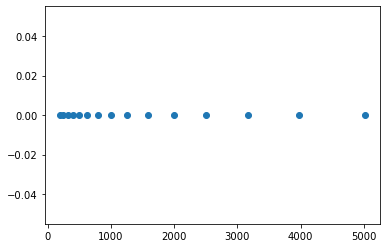

In [21]:
a = np.logspace(2.3, 3.7, 15, endpoint=True)
plt.plot(a, np.zeros(15), 'o')
a

In [22]:
%%time
max_features_list = np.logspace(2.3, 3.7, 15, endpoint=True, dtype=int)   # De 10^2 à 10^3.8
table = []
for max_features in max_features_list:
    _, _, _, _, _, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = max_features), LogisticRegression(max_iter=200), verbose=False)
    table.append(metrics_score)
df = pd.DataFrame(table, index=max_features_list)

Wall time: 6min 19s


[]

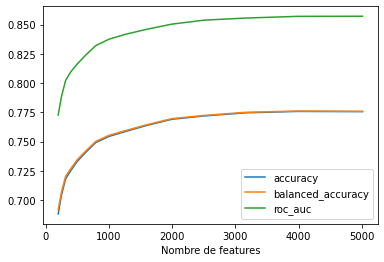

In [23]:
for i in df.columns:
    df[i].plot(label=i)

plt.legend()
plt.xlabel("Nombre de features")
plt.plot()

### 3.3.2 Pré-processing fixé et variation des méthodes de feature extraction

On garde le pré-processing fixé et on fait varier les méthodes de feature extraction.

In [24]:
def influence_features(X, y, max_features_list):
    table = []
    for max_features in max_features_list:
        _, _, _, _, _, metrics_score = conf_matrix(X, y, CountVectorizer(max_features=max_features), LogisticRegression(max_iter=200), verbose=False)
        metrics_score['features'] = max_features
        metrics_score['method'] = "CountVectorizer"
        table.append(metrics_score)

        _, _, _, _, _, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features=max_features), LogisticRegression(max_iter=200), verbose=False)
        metrics_score['features'] = max_features
        metrics_score['method'] = "TfidfVectorizer"
        table.append(metrics_score)

        _, _, _, _, _, metrics_score = conf_matrix(X, y, CountVectorizer(max_features=max_features, ngram_range=(2,2)), LogisticRegression(max_iter=200), verbose=False)
        metrics_score['features'] = max_features
        metrics_score['method'] = "CountVectorizer ngram 2"
        table.append(metrics_score)

        _, _, _, _, _, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features=max_features, ngram_range=(2,2)), LogisticRegression(max_iter=200), verbose=False)
        metrics_score['features'] = max_features
        metrics_score['method'] = "TfidfVectorizer ngram 2"
        table.append(metrics_score)

    df = pd.DataFrame(table)

    methods = list(set(df.method))
    scores = list(df.columns[:-2])
    fig, axes = plt.subplots(1, len(scores), figsize=(20, 6))
    for i_score in range(len(scores)):
        for j_method in range(len(methods)):
            df[df.method == methods[j_method]].plot(x='features', y=scores[i_score], label=methods[j_method], ax=axes[i_score])
        axes[i_score].set(xlabel='Nombre de features')
        axes[i_score].legend()
        axes[i_score].set_title(scores[i_score])
    plt.plot()
    return df

Wall time: 29min 20s


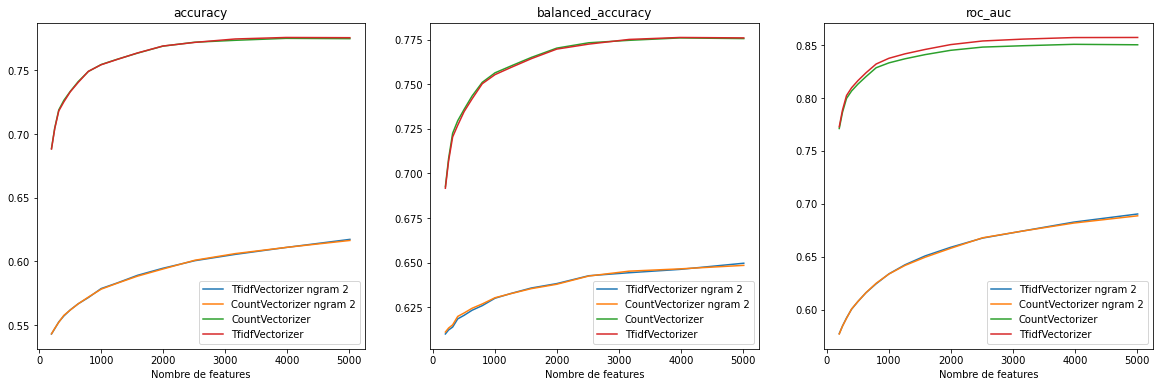

In [25]:
%%time
_ = influence_features(X, y, max_features_list)

### 3.3.3. Variations du pré-processing et des méthodes de feature extraction

Nous faisons à présent tout varier (pré-processing, feature extraction).

stop_words: False, lemmatization: False, negation: False
stop_words: False, lemmatization: False, negation: True
stop_words: False, lemmatization: True, negation: False
stop_words: False, lemmatization: True, negation: True
stop_words: True, lemmatization: False, negation: False


C:\Users\pasqu\anaconda3\envs\data-2A\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\pasqu\anaconda3\envs\data-2A\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

stop_words: True, lemmatization: False, negation: True


C:\Users\pasqu\anaconda3\envs\data-2A\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


stop_words: True, lemmatization: True, negation: False
stop_words: True, lemmatization: True, negation: True
Wall time: 4h 9min 53s


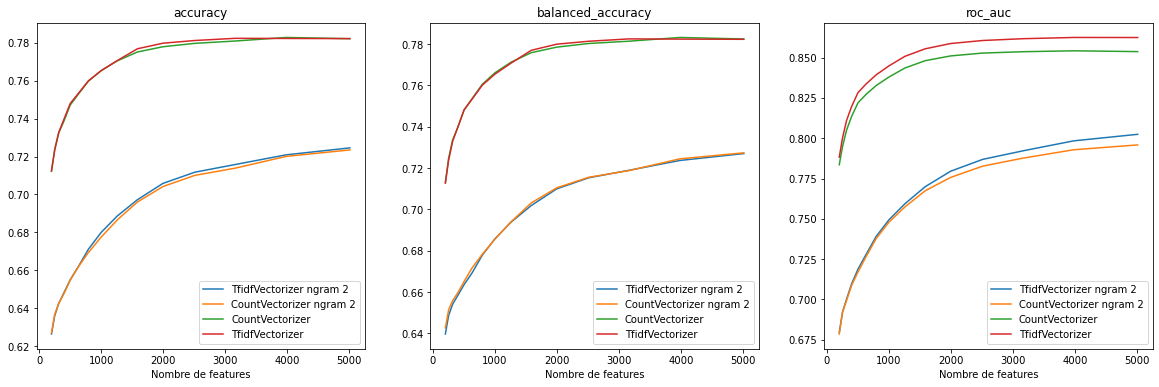

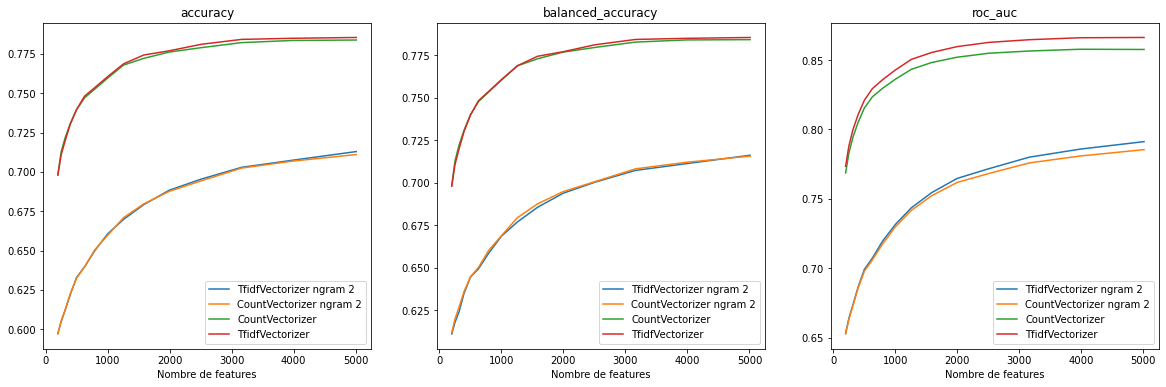

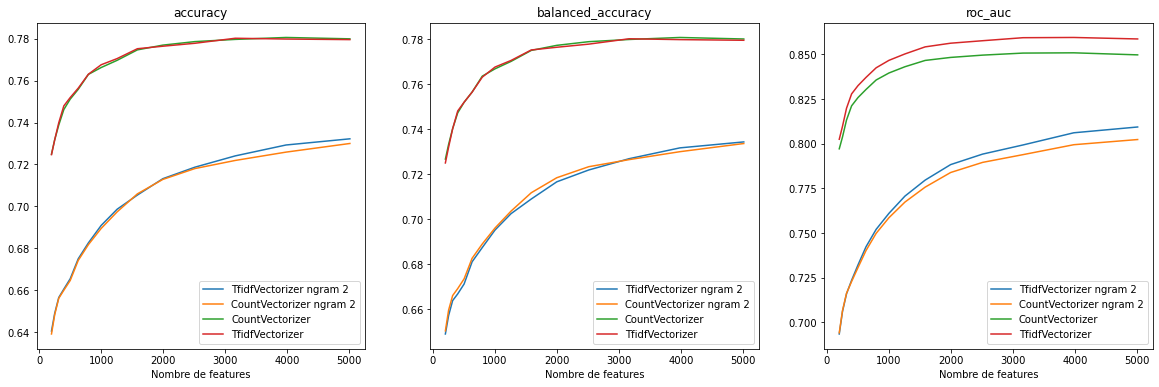

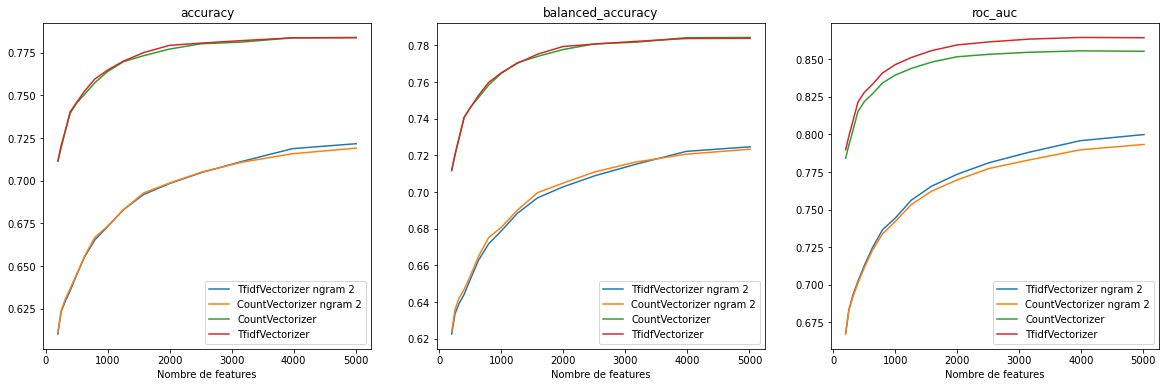

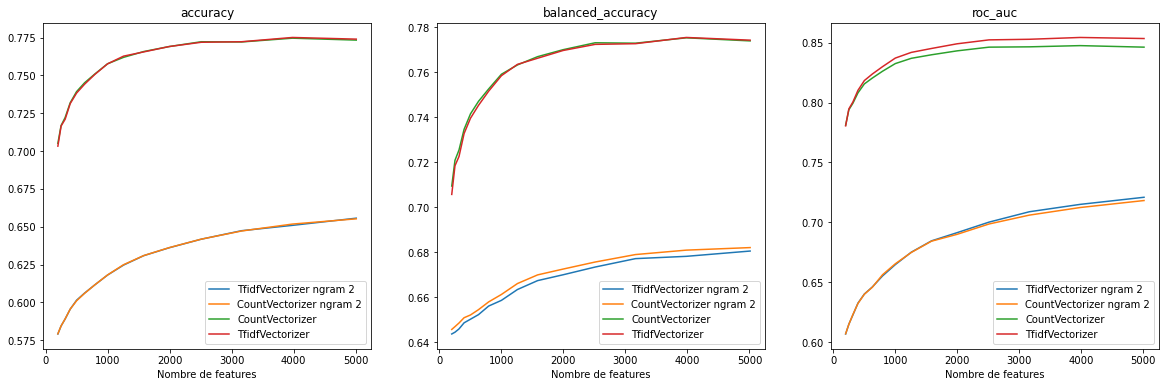

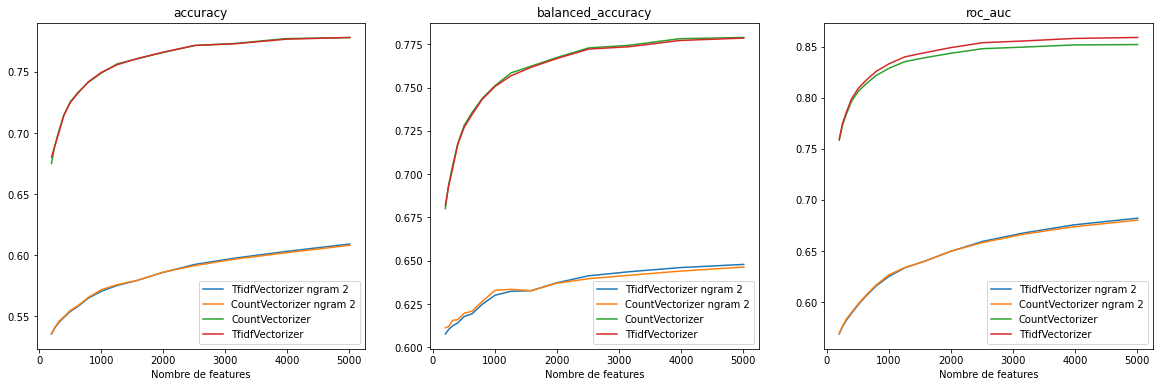

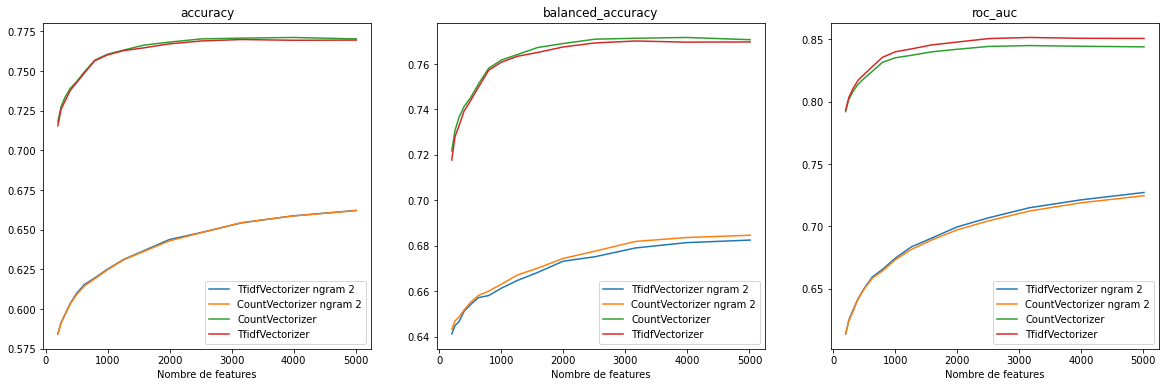

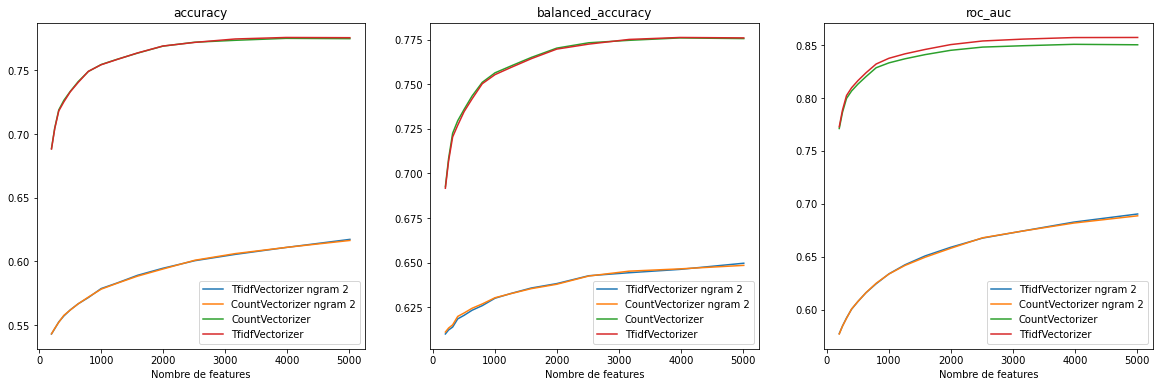

In [26]:
%%time
tables = []
for stop_words in [False, True]:
    for lemmatization in [False, True]:
        for negation in [False, True]:
            file = "train"
            if stop_words:
                file += "_stop"
            if lemmatization:
                file += "_lemm"
            if  negation:
                file += "_neg"
            print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
            df = pd.read_pickle(os.path.join("data", "sentiment140", file+".bz2")).sample(NB_DATA, random_state=1234)
            X = df.text.to_list()
            y = df.sentiment.to_list()
            df_metrics = influence_features(X, y, max_features_list)
            df_metrics['stop_words'] = stop_words
            df_metrics['lemmatization'] = lemmatization
            df_metrics['negation'] = negation
            tables.append(df_metrics)
df_metrics = pd.concat(tables)

In [27]:
df_metrics

,accuracy,balanced_accuracy,roc_auc,features,method,stop_words,lemmatization,negation
0,0.712200,0.713164,0.783517,199,CountVectorizer,False,False,False
1,0.712525,0.712694,0.788260,199,TfidfVectorizer,False,False,False
2,0.627000,0.642718,0.678528,199,CountVectorizer ngram 2,False,False,False
3,0.626400,0.639747,0.679387,199,TfidfVectorizer ngram 2,False,False,False
4,0.723700,0.724733,0.794741,251,CountVectorizer,False,False,False
...,...,...,...,...,...,...,...,...
55,0.611000,0.646212,0.682631,3981,TfidfVectorizer ngram 2,True,True,True
56,0.774875,0.775545,0.850249,5011,CountVectorizer,True,True,True
57,0.775650,0.775941,0.857167,5011,TfidfVectorizer,True,True,True
58,0.616500,0.648462,0.688578,5011,CountVectorizer ngram 2,True,True,True


In [28]:
df_metrics.sort_values(by="roc_auc")

,accuracy,balanced_accuracy,roc_auc,features,method,stop_words,lemmatization,negation
3,0.535500,0.607662,0.568809,199,TfidfVectorizer ngram 2,True,False,True
2,0.535850,0.611298,0.569368,199,CountVectorizer ngram 2,True,False,True
7,0.540325,0.610223,0.575885,251,TfidfVectorizer ngram 2,True,False,True
6,0.540625,0.611887,0.576456,251,CountVectorizer ngram 2,True,False,True
2,0.543225,0.611089,0.576877,199,CountVectorizer ngram 2,True,True,True
...,...,...,...,...,...,...,...,...
57,0.783725,0.783844,0.864446,5011,TfidfVectorizer,False,True,True
49,0.784225,0.784385,0.864592,3162,TfidfVectorizer,False,False,True
53,0.783625,0.783743,0.864609,3981,TfidfVectorizer,False,True,True
53,0.784925,0.785050,0.865999,3981,TfidfVectorizer,False,False,True


In [34]:
for elem in ['features', 'method', 'stop_words', 'lemmatization', 'negation']:
    display(df_metrics.groupby(elem).mean().sort_values(by="roc_auc", ascending=False))

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
features,,,,,,
5011,0.728630,0.737018,0.802915,0.5,0.5,0.5
3981,0.726525,0.735809,0.800504,0.5,0.5,0.5
3162,0.723288,0.733433,0.796736,0.5,0.5,0.5
2511,0.719772,0.730708,0.792689,0.5,0.5,0.5
1995,0.715402,0.727061,0.787455,0.5,0.5,0.5
1584,0.710229,0.722707,0.781517,0.5,0.5,0.5
1258,0.704539,0.717878,0.775153,0.5,0.5,0.5
1000,0.698330,0.712452,0.767907,0.5,0.5,0.5
794,0.691837,0.706724,0.760357,0.5,0.5,0.5


,accuracy,balanced_accuracy,roc_auc,features,stop_words,lemmatization,negation
method,,,,,,,
TfidfVectorizer,0.753095,0.753735,0.833744,1572.733333,0.5,0.5,0.5
CountVectorizer,0.752972,0.754284,0.828122,1572.733333,0.5,0.5,0.5
TfidfVectorizer ngram 2,0.636366,0.663145,0.696547,1572.733333,0.5,0.5,0.5
CountVectorizer ngram 2,0.636074,0.664465,0.694926,1572.733333,0.5,0.5,0.5


,accuracy,balanced_accuracy,roc_auc,features,lemmatization,negation
stop_words,,,,,,
False,0.716194,0.720196,0.788712,1572.733333,0.5,0.5
True,0.673060,0.697618,0.737957,1572.733333,0.5,0.5


,accuracy,balanced_accuracy,roc_auc,features,stop_words,negation
lemmatization,,,,,,
True,0.697975,0.711285,0.766798,1572.733333,0.5,0.5
False,0.691278,0.706529,0.759871,1572.733333,0.5,0.5


,accuracy,balanced_accuracy,roc_auc,features,stop_words,lemmatization
negation,,,,,,
False,0.704399,0.716787,0.771392,1572.733333,0.5,0.5
True,0.684855,0.701027,0.755277,1572.733333,0.5,0.5


In [35]:
for elem in ['features', 'method', 'stop_words', 'lemmatization', 'negation']:
    display(df_metrics.groupby(elem).mean().sort_values(by="balanced_accuracy", ascending=False))

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
features,,,,,,
5011,0.728630,0.737018,0.802915,0.5,0.5,0.5
3981,0.726525,0.735809,0.800504,0.5,0.5,0.5
3162,0.723288,0.733433,0.796736,0.5,0.5,0.5
2511,0.719772,0.730708,0.792689,0.5,0.5,0.5
1995,0.715402,0.727061,0.787455,0.5,0.5,0.5
1584,0.710229,0.722707,0.781517,0.5,0.5,0.5
1258,0.704539,0.717878,0.775153,0.5,0.5,0.5
1000,0.698330,0.712452,0.767907,0.5,0.5,0.5
794,0.691837,0.706724,0.760357,0.5,0.5,0.5


,accuracy,balanced_accuracy,roc_auc,features,stop_words,lemmatization,negation
method,,,,,,,
CountVectorizer,0.752972,0.754284,0.828122,1572.733333,0.5,0.5,0.5
TfidfVectorizer,0.753095,0.753735,0.833744,1572.733333,0.5,0.5,0.5
CountVectorizer ngram 2,0.636074,0.664465,0.694926,1572.733333,0.5,0.5,0.5
TfidfVectorizer ngram 2,0.636366,0.663145,0.696547,1572.733333,0.5,0.5,0.5


,accuracy,balanced_accuracy,roc_auc,features,lemmatization,negation
stop_words,,,,,,
False,0.716194,0.720196,0.788712,1572.733333,0.5,0.5
True,0.673060,0.697618,0.737957,1572.733333,0.5,0.5


,accuracy,balanced_accuracy,roc_auc,features,stop_words,negation
lemmatization,,,,,,
True,0.697975,0.711285,0.766798,1572.733333,0.5,0.5
False,0.691278,0.706529,0.759871,1572.733333,0.5,0.5


,accuracy,balanced_accuracy,roc_auc,features,stop_words,lemmatization
negation,,,,,,
False,0.704399,0.716787,0.771392,1572.733333,0.5,0.5
True,0.684855,0.701027,0.755277,1572.733333,0.5,0.5


In [ ]:
print(f"Temps total : {time.time() - a}")